In [3]:
import fiona
import pandas as pd, numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import json
import requests
import pprint
pp = pprint.PrettyPrinter()
#import os
#from mapboxgl.viz import *
#from mapboxgl.utils import *
from geojson import Feature, Point, FeatureCollection

In [4]:
#!pip install mapboxgl

#token = 'INSERT TOKEN HERE'

### Load tract shapefile to use as base map

In [122]:
tracts = gpd.read_file('Tracts/cb_2017_06_tract_500k.shp')

In [123]:
tracts.crs

{'init': 'epsg:4269'}

### Load our bus transit layer

In [131]:
our_layer = gpd.read_file('our_layer/geo_stops.shp')

print(our_layer.crs)
our_layer = our_layer.to_crs(tracts.crs)
print(our_layer.crs)

{'init': 'epsg:26910'}
{'init': 'epsg:4269'}


In [150]:
#Dissolve so it's easier to plot
our_layer2 = our_layer.dissolve('Agency')
print(our_layer2.crs)

{'init': 'epsg:4269'}


### Now import the Transit Rich Housing layer and turn into a geodataframe

For now I'm just importing the "no_rise_shape". This corresponds to the bus layer. It is incomplete since it doesn't include where the bus layer overlaps with the rail layer, which is annoying.

In [89]:
with open('no_rise_shape.json') as json_data:
    data = json.load(json_data,) 

In [90]:
#pp.pprint(data[0])

In [91]:
print(data[0][1]['lat'])

32.576176


In [92]:
print(data[0][0].values())

dict_values([32.576063, -117.059311])


In [93]:
print(list(zip(data[0][0].values())))

[(32.576063,), (-117.059311,)]


In [109]:
lats = []
longs = []
for i in list(range(0,len(data[0]))):
    lats.append(data[0][i]['lat'])
    longs.append(data[0][i]['lng'])
    
poly1 = list(zip(longs, lats))

shape = gpd.GeoSeries([Polygon(poly1)])
all_shapes = gpd.GeoDataFrame({'geometry': shape})


In [111]:
for j in list(range(1,len(data))):
    lats = []
    longs = []
    for i in list(range(0,len(data[j]))):
        lats.append(data[j][i]['lat'])
        longs.append(data[j][i]['lng'])

    poly1 = list(zip(longs, lats))

    shape = gpd.GeoSeries([Polygon(poly1)])
    shape = gpd.GeoDataFrame({'geometry': shape})
    
    all_shapes = gpd.GeoDataFrame(pd.concat([all_shapes, shape], ignore_index=True))

In [112]:
all_shapes['test']=2

In [113]:
all_shapes.head(3)

,geometry,test
0,"POLYGON ((-117.059311 32.576063, -117.059163 3...",2
1,"POLYGON ((-117.081829 32.640899, -117.082106 3...",2
2,"POLYGON ((-117.101263 32.673775, -117.101525 3...",2


In [114]:
all_shapes.crs = {'init' :'epsg:4269'}
#mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
#all_shapes = all_shapes.to_crs(mtc_crs)

### Time to plot!

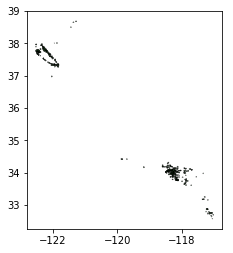

In [115]:
all_shapes.plot(color='green', edgecolor='k', alpha=0.5)

#### Here is Oakland

There is something weird happening with the polygons. First of all, it is cutting out the rail buffers so you have to imagine that those are there, lol.

Secondly, the insides of some of the polygons are getting colored in. The dark blue areas should actually be blank. I'm not sure why they're being colored in.

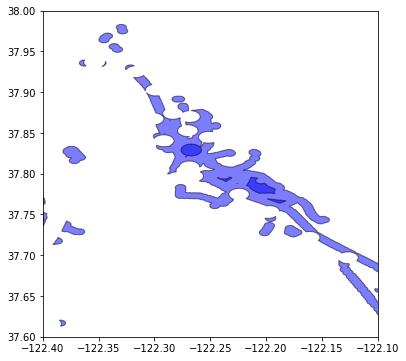

In [160]:
fig, ax = plt.subplots(figsize=(6,6))
plt.xlim(-122.4,-122.1)
plt.ylim(37.6,38)
all_shapes.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3)
plt.show()

#### Here is the comparison

Transit Rich Housing is the bottom layer, in blue

Our Layer is the top layer in yellow

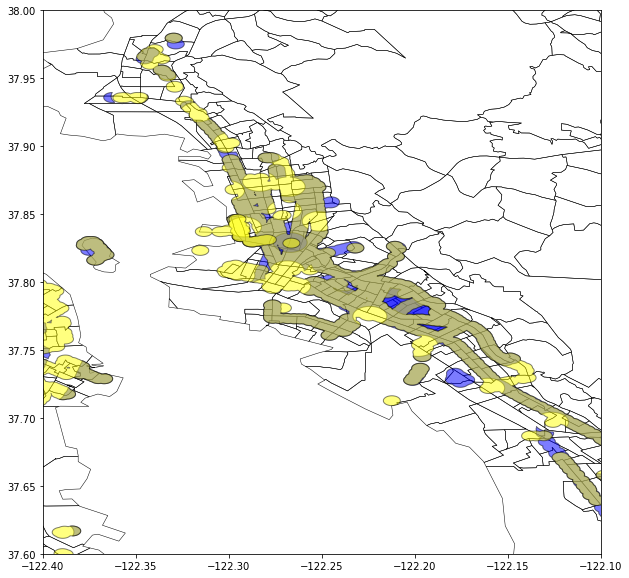

In [153]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-122.4,-122.1)
plt.ylim(37.6,38)
ax = tracts.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
ax = all_shapes.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3)
our_layer2.plot(ax=ax, color='yellow', edgecolor='k', alpha=0.5)
plt.show()

#### Here is the Los Angeles Area.

We're doing pretty good!!!

Looks like we're capturing a little more than we should be in Central and South LA though. I'd rather be over-inclusive than under-inclusive

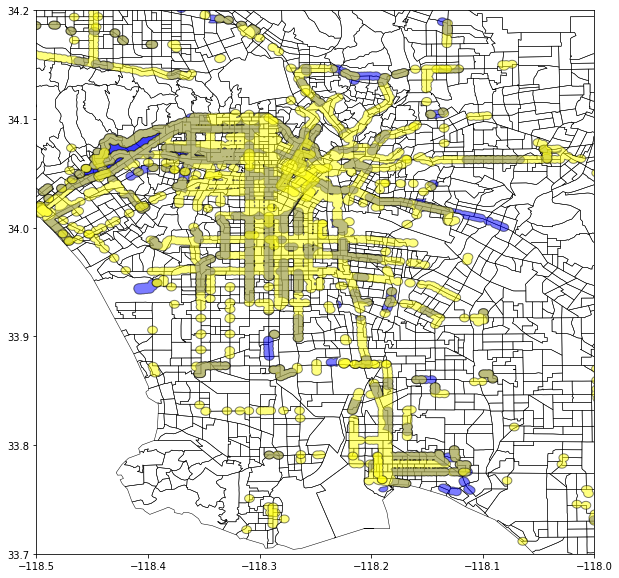

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-118.5,-118)
plt.ylim(33.7,34.2)
ax = tracts.plot(ax=ax, color='none', edgecolor='k', linewidth=0.5)
ax = all_shapes.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3)
our_layer2.plot(ax=ax, color='yellow', edgecolor='k', alpha=0.5)
plt.show()

### Massive fail trying to export as geojson and use the mapbox web mapping tool

In [49]:
with open('all_shapes.geojson', 'w') as f:
    f.write(all_shapes.to_json())

In [50]:
test = GeoDataFrame.from_file('all_shapes.geojson')
test.head()

,id,test,geometry
0,0,2,"POLYGON ((32.576063 -117.059311, 32.576176 -11..."
1,1,2,"POLYGON ((32.640899 -117.081829, 32.640726 -11..."
2,2,2,"POLYGON ((32.673775 -117.101263, 32.673643 -11..."
3,3,2,"POLYGON ((32.70017 -117.023993, 32.700053 -117..."
4,4,2,"POLYGON ((33.153971 -117.191253, 33.153946 -11..."


In [80]:
with open('all_shapes.geojson') as json_data:
    data2 = json.load(json_data,) 
    
#pp.pprint(data2)

In [121]:
viz = ChoroplethViz('test.json', 
                    access_token=token,
                    color_property='test',
                    color_stops=create_color_stops([0, 50, 100, 500, 1500], colors='Purples'),
                    color_function_type='interpolate',
                    line_stroke='-',
                    line_color='rgb(128,0,38)',
                    line_width=1,
                    opacity=0.8,
                    center=(-96, 37.8),
                    zoom=3,
                    below_layer='waterway-label',
                    legend_layout='horizontal',
                    legend_key_shape='bar',
                    legend_key_borders_on=False)
#viz.show()